In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.optimize
import scipy.stats
import random

# Maximum Likelihood Estimation for Ornstein-Uhlenbeck Processes

Author: Kaiwen Zhang, Shi Feng, Wencheng Bao

In this demo, we implement the Maximum Likelihood Estimation (MLE) method for parameter inference in the Ornstein-Uhlenbeck (OU) process. In the case of purely Brownian noise, the task is simple because the likelihood function can be computed analytically.

## 1. OU Process with Purely Brownian Noise

We follow the formula $$dX_t = \theta (\mu - X_t) dt + \sigma dW_t$$ for OU process, and discretize the SDE with the Euler-Maruyama method. The resulting discrete scheme is: $$X_{i+1} = X_i + \theta (\mu - X_i)dt + \sigma Z_i$$ where $Z_i \sim N(0, dt)$, $dt$ is variance.

With a given time series data generated by the above SDE, the likelihood function of paramaters can be computed using the condition densities $p(X_{i+1}|X_i)$. Indeed, with $X_i$ given, $X_{i+1}$ follows a normal distribution centered at $X_i + \theta(\mu - X_i) dt$, with variance $\sigma^2 dt$.

Note: because the large size of data, it is not practical to compute the exact likelihood function. We instead compute the log likelihood function. Since logarithm is monotone, optimizing the log likelihood is equivalent to optimizing likelihood.

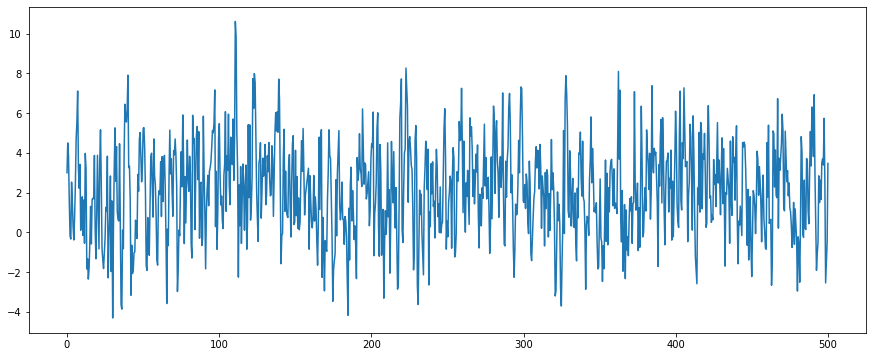

In [2]:
# genrate data, OU process discretized
# dX_t = theta (mu - X_t) dt + sigma dW_t
N = 1000 # data size
t = np.linspace(0, 500, N) # time

# set parameters manually first, we look to reconstruct them
theta = 1
mu = 2
sigma = 3
x_init = 3 # the first data point, manually set and not reconstructed

# Euler-Maruyama simulation of OU process
def sim_OU(params, time):
    """
    Input:
    - params: parameters in the model, follow the order [theta, mu, sigma, x_init]
    - time: a numpy array of time variable, used to compute dt
    Output:
    - a numpy array of length time.size, consisting of simulated OU process
    """
    theta, mu, sigma, x_init = (params[0], params[1], params[2], params[3])
    res = np.zeros(time.shape[0])
    res[0] = x_init
    for i in range(time.shape[0] - 1):
        dt = time[i+1] - time[i]
        res[i+1] = res[i] + theta * (mu - res[i]) * dt + sigma * np.random.normal(0, np.sqrt(dt))
    return res

X = sim_OU(params=[theta, mu, sigma, x_init], time = t)
# plot data
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X)

In [3]:
# construct likelihood function

def normal_pdf(mean, var, x):
    """
    a function for computing the normal pdf value at given point
    """
    return (1 / (np.sqrt(2 * np.pi * var))) * np.exp(- 0.5 * ((x - mean)/np.sqrt(var))**2)

def neg_log_likelihood(params, data, time):
    """
    Computes the negative log likelihood function given the time series data, to be minimized
    Input: 
    - params: parameters of the SDE, in order [theta, mu, sigma]
    - data: the observed time series data
    - time: time array, used for dt computation
    Output:
    - the negative log likelihood of observing the given data, given the inputed parameters
    """
    
    theta = params[0]
    mu = params[1]
    sigma = params[2]
    log_likelihood = 0
    for j in range(1, data.shape[0]-1):
        dt = time[j] - time[j-1]
        log_likelihood = log_likelihood + np.log(normal_pdf(data[j-1]+theta*(mu-data[j-1])*dt, sigma**2*dt, data[j]))
    
    return -log_likelihood

In [4]:
# optimize the likelihood function and output reconstructed parameters

params_mle = scipy.optimize.minimize(neg_log_likelihood, x0 = [0.5, 1, 2], args=(X, t)).x
print("reconstructed parameters: [theta, mu, sigma] =", params_mle)
print("original parameters:      [theta, mu, sigma] =", [theta, mu, sigma])

reconstructed parameters: [theta, mu, sigma] = [1.05680946 2.08796246 2.94069692]
original parameters:      [theta, mu, sigma] = [1, 2, 3]


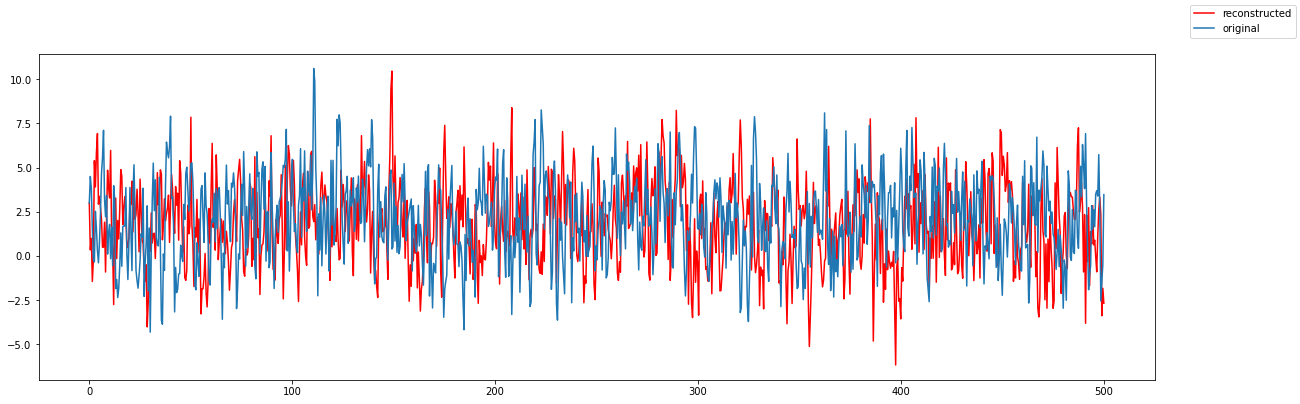

In [5]:
# plot the reconstructed data
params_mle_3 = np.append(params_mle, [x_init])
X_rec = sim_OU(params_mle_3, time=t)

# plot data
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X_rec, 'r', label = "reconstructed")
ax.plot(t, X, label = "original")
fig.legend()
plt.show()

## 2. OU Process with Jump, in Addition to Brownian Noise
One can make the OU process a more realistic model by adding a jump term into the SDE. This noise addition makes MLE more difficult, because the likelihood function can no longer be easily computed analytically.

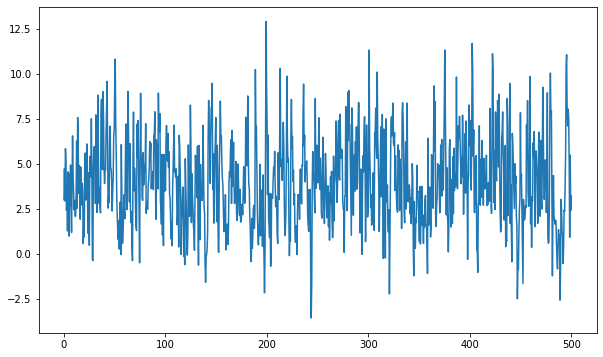

In [6]:
# genrate data, OU process discretized
# dX_t = theta (mu - X_t) dt + sigma dW_t + J_t
N = 1000 # data size
t = np.linspace(0, 500, N) # time

# set parameters manually first, we look to reconstruct them
theta = 1
mu = 1.2
sigma = 1.5
x_init = 3

lambda_j = 1
mu_j = 2
sigma_j = 2

# Euler-Maruyama
def sim_OU_jump(params, time):
    theta, mu, sigma, x_init = (params[0], params[1], params[2], params[3])
    lambda_j, mu_j, sigma_j = (params[4], params[5], params[6])
    X_j = np.zeros(time.shape[0])
    X_j[0] = x_init
    for i in range(time.shape[0]-1):
        dt = time[i+1] - time[i]
        X_j[i+1] = X_j[i] + theta * (mu - X_j[i]) * dt + sigma * np.random.normal(0, np.sqrt(dt))
        if np.random.normal(0, 1) < lambda_j * dt:
            X_j[i+1] += np.random.normal(mu_j, sigma_j)
    
    return X_j

# plot data
X_jump = sim_OU_jump(params=[theta, mu, sigma, x_init, lambda_j, mu_j, sigma_j], time = t)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X_jump)

We first try to apply the exact same formula as in section 1 to estimate parameters $\theta, \mu, \sigma$. As shown below, the result is not satisfactory.

Reconstructed paramaters: [theta, mu, sigma] = [1.03935875 3.97308714 3.09816767]
Original parameters:      [theta, mu, sigma] = [1, 1.2, 1.5]


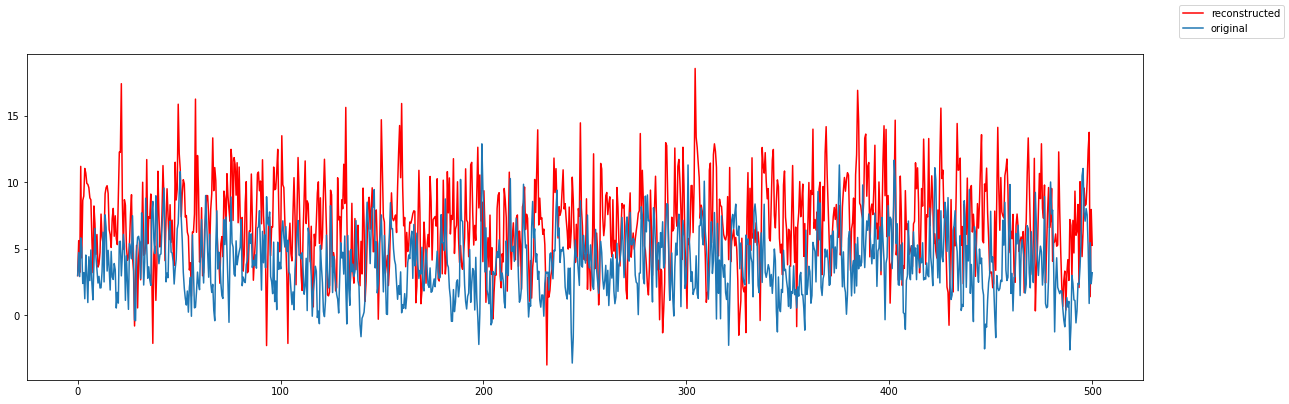

In [7]:
params_jump_mle = scipy.optimize.minimize(neg_log_likelihood, x0 = [0.5, 1, 2], args=(X_jump, t)).x
print("Reconstructed paramaters: [theta, mu, sigma] =", params_jump_mle)
print("Original parameters:      [theta, mu, sigma] =", [theta, mu, sigma])


# plot the reconstructed data
params_rec_cplt = np.append(params_jump_mle, [x_init, lambda_j, mu_j, sigma_j])

X_jump_rec = sim_OU_jump(params = params_rec_cplt, time = t)
# plot data
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X_jump_rec, 'r', label = "reconstructed")
ax.plot(t, X_jump, label = "original")
fig.legend()
plt.show()